In [65]:
import tensorflow as tf
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import numpy as np


In [73]:
model_dir = '../animal_classifier/models/'
models = ['augmented_full_val_correct']
epochs = [0,16,32,48,64]

train_dir = '../animal_classifier/dataset/train'

validate_dir = '../animal_classifier/dataset/validate'
batch_size = 1

example_dir = ''

data_output_dir = ''

epsilons = [0, .01, .1, .15]

In [32]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, labels='inferred')
validate_dataset = tf.keras.preprocessing.image_dataset_from_directory(validate_dir, labels='inferred')

Found 8000 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.


In [47]:
def preprocess(image, model):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (256,256))
    # image = model.preprocess_input(image)
    image = image[None, ...] #adds that goofy empty dimension
    return image


In [34]:
def create_adversarial_pattern(input_image, input_label, model):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = tf.keras.losses.MSE(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [52]:
image_paths = []
classes = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
for root, dir, files in os.walk(validate_dir, topdown=False):
    print(root)
    if('\\' in root):
        label = classes.index(root.split('\\')[1])
        image_paths += ([{'label': label, 'path': root + '/' + file} for file in files])

../animal_classifier/dataset/validate\butterfly
../animal_classifier/dataset/validate\cat
../animal_classifier/dataset/validate\chicken
../animal_classifier/dataset/validate\cow
../animal_classifier/dataset/validate\dog
../animal_classifier/dataset/validate\elephant
../animal_classifier/dataset/validate\horse
../animal_classifier/dataset/validate\sheep
../animal_classifier/dataset/validate\spider
../animal_classifier/dataset/validate\squirrel
../animal_classifier/dataset/validate


tf.Tensor(
[[[107.  93.  90.]
  [106.  92.  89.]
  [110.  95.  92.]
  ...
  [ 87.  79.  77.]
  [ 78.  70.  68.]
  [ 87.  79.  77.]]

 [[107.  93.  90.]
  [106.  92.  89.]
  [110.  95.  92.]
  ...
  [ 85.  77.  75.]
  [ 75.  67.  65.]
  [ 78.  70.  68.]]

 [[107.  93.  90.]
  [107.  93.  90.]
  [111.  96.  93.]
  ...
  [ 64.  56.  54.]
  [ 60.  52.  50.]
  [ 71.  63.  61.]]

 ...

 [[159. 144. 141.]
  [203. 190. 184.]
  [217. 208. 199.]
  ...
  [ 71. 115.  54.]
  [ 77. 117.  57.]
  [ 74. 103.  47.]]

 [[144. 128. 128.]
  [177. 163. 160.]
  [203. 194. 187.]
  ...
  [ 90. 131.  71.]
  [ 86. 122.  61.]
  [101. 126.  69.]]

 [[153. 137. 138.]
  [159. 145. 144.]
  [179. 170. 165.]
  ...
  [120. 160. 100.]
  [ 81. 115.  55.]
  [ 74.  97.  41.]]], shape=(300, 241, 3), dtype=float32)
tf.Tensor(
[[[254. 255. 250.]
  [254. 255. 250.]
  [254. 255. 250.]
  ...
  [ 26.  27.  21.]
  [ 27.  28.  22.]
  [ 28.  29.  23.]]

 [[252. 253. 248.]
  [252. 253. 248.]
  [252. 253. 248.]
  ...
  [ 26.  27.  21.]

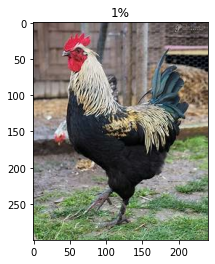

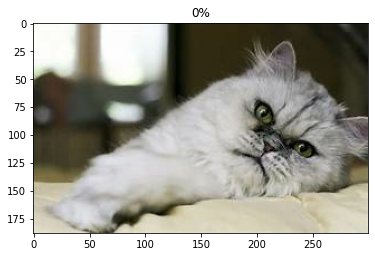

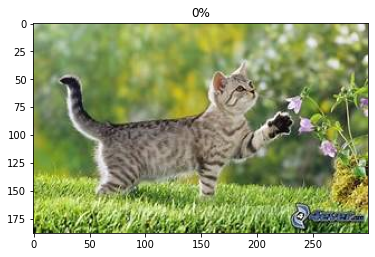

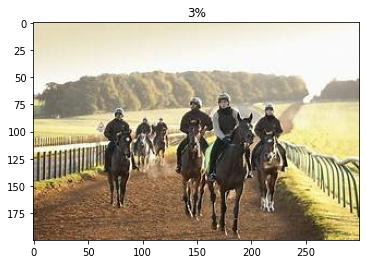

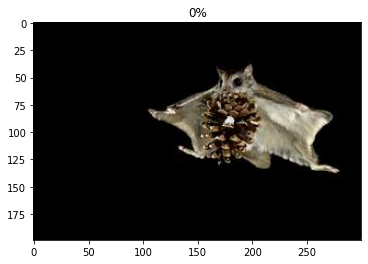

In [80]:
for model_name in models:
    model_path = model_dir + model_name + '/' + model_name

    data = []

    for epoch in epochs:
        model = tf.keras.models.load_model(model_path + '_' + str(epoch))
        model.trainable = False
        # [loss, accuracy] = model.evaluate(validate_dataset, batch_size=batch_size)
        # train_accuracy = model.evaluate(train_dataset, batch_size=batch_size)[1]

        # Create adversarial dataset
        
        indicies = random.sample(range(0,len(image_paths)-1),batch_size)
        metrics = {'n': 0, 'loss_sum': 0, 'accuracy_sum': 0, 'example_loss_sum': 0, 'example_accuracy_sum': 0}

        for index in indicies:
            image_raw = tf.io.read_file(image_paths[index]['path'])
            image = tf.image.decode_image(image_raw, channels=3)
            label = image_paths[index]['label']
            
            image = preprocess(image, model)
            image_probs = model.predict(image)[0]
            result = np.argmax(image_probs)
            perterbations = create_adversarial_pattern(image,label, model)
            plt.figure()
            plt.imshow(perterbations[0] * 0.5 + 0.5)
            plt.imshow(tf.cast(tf.image.decode_image(image_raw, channels=3), tf.float32) / 255)
            plt.title(str(result) + '%')
            metrics['n'] += 1

        # [example_loss, example_accuracy] = model.evaluate(example_dataset, batch_size=batch_size)

        # data.append({'epoch': epoch, 'loss': loss, 'accuracy': accuracy, 'train_accuracy': train_accuracy, 'example_loss': example_loss, 'example_accuracy': example_accuracy, 'batch_size': batch_size})
        
    # df = pd.DataFrame(data)
    # print(df)
    # df.to_csv(path_or_buf=data_output_dir)


        